In [1]:
import pandas as pd
import numpy as np

In [2]:

# df = pd.read_csv('/home/bowen/Documents/Rod_manipulation/Flexible-Tool/data_2.csv', sep = " ", names = ['name', 'value'])

df = pd.read_csv('/home/ana/Documents/Code/Flexible-Tool/data_2.csv', sep = " ", names = ['name', 'value'])


In [3]:

df.dropna(inplace = True)
df


,name,value
0,a,[0.6152792 0.57624728 0.97183159 0.30227324 0...
1,q,"[[1.0, 0.99996588008, 0.99989695401, 0.9997925..."
2,det_J,"[0.0, 0.0, 0.0, 0.0, -2.53263925567196e-87, 2...."
3,a,[0.42157321 0.04321076 0.28883865 0.53631535 0...
4,q,"[[1.0, 0.99999984126, 0.99999948152, 0.9999988..."
...,...,...
2995,q,"[[1.0, 0.99991970255, 0.99975684995, 0.9995091..."
2996,det_J,"[0.0, 0.0, 0.0, 0.0, 1.4138451607417442e-86, -..."
2997,a,[0.18525751 0.06743073 0.86360801 0.0865571 0...
2998,q,"[[1.0, 0.99999969828, 0.9999992522, 0.99999881..."


In [4]:
df2 = pd.DataFrame()
for r in range(len(df)):
    if r % 3 == 0:
        df0 = df.iloc[r,1:]
        df0.value
        df0 = df0.str.strip('[[[ ')
        df0 = df0.str.strip('[]')
        df0 = df0.value.split()
        df0 = np.array(df0,dtype=float)
        df2 = df2.append(pd.DataFrame(df0))




In [5]:
df2.head(12)
df2.shape

(6000, 1)

In [6]:
df2.shape

(6000, 1)

In [7]:
df3 = pd.DataFrame()
for i in range(len(df)):
    if i % 3 == 1:
        df1 = df.iloc[i,1:]
        df1 = df1.value
        df1 = df1.replace('[','')
        df1 = df1.replace(']','')
        df1 = df1.split(',')
        df1 = np.array(df1,dtype=float)
        df3 = df3.append(pd.DataFrame(df1))


In [8]:
df3.shape

(1600000, 1)

In [9]:
type(df3)

pandas.core.frame.DataFrame

In [10]:
q_array = df3.to_numpy()
tmp = []
for r in q_array:
    tmp.append(np.transpose(np.asarray([r])).astype(np.float32))
q_array = np.asarray(tmp.copy())
type(q_array)

numpy.ndarray

In [11]:
q_array = q_array.reshape(1000,16,100)
q_array.shape

(1000, 16, 100)

In [12]:
a_array = df2.to_numpy()
tmp2 = []
for i in a_array:
    tmp2.append(np.transpose(np.asarray([i])).astype(np.float32))
a_array = np.asarray(tmp2.copy())

In [13]:
a_array = a_array.reshape(1000,6)
a_array.shape

(1000, 6)

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [15]:
train_x = (q_array[0:800,:,:]).astype(np.float32) # training data from csv/pandas (80% of existing data?)
test_x = (q_array[800:-1,:,:]).astype(np.float32) # test data from csv/pandas (remaining ~20% of data)
test_x = np.expand_dims(test_x, 1) # add dimension for neural net

train_y = (a_array[0:800,:]).astype(np.float32)
test_y = (a_array[0:800,:]).astype(np.float32)
type(train_x)

x_test_tensor = torch.from_numpy(test_x)
y_test_tensor = torch.from_numpy(test_y)
test_data = [(x_test_tensor[i],y_test_tensor[i]) for i in range(len(test_x))]
print("test_data shape ", test_data)



test_data shape  [(tensor([[[ 1.0000e+00,  9.9999e-01,  9.9998e-01,  ...,  9.5299e-01,
           9.5156e-01,  9.5010e-01],
         [ 0.0000e+00,  6.5486e-05,  1.9621e-04,  ...,  3.1131e-01,
           3.1814e-01,  3.2505e-01],
         [ 0.0000e+00,  2.5888e-03,  5.1986e-03,  ...,  2.5226e-01,
           2.5379e-01,  2.5526e-01],
         ...,
         [ 0.0000e+00,  6.4831e-03,  1.2942e-02,  ...,  6.2397e-01,
           6.3152e-01,  6.3913e-01],
         [ 0.0000e+00, -4.2129e-05, -1.2616e-04,  ..., -1.8753e-01,
          -1.9151e-01, -1.9555e-01],
         [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0179e+00,
           1.0182e+00,  1.0186e+00]]]), tensor([0.6153, 0.5762, 0.9718, 0.3023, 0.2811, 0.7125])), (tensor([[[ 1.0000e+00,  9.9994e-01,  9.9981e-01,  ...,  6.9509e-01,
           6.8836e-01,  6.8155e-01],
         [ 0.0000e+00,  6.3134e-05,  1.8893e-04,  ...,  2.6047e-01,
           2.6566e-01,  2.7091e-01],
         [ 0.0000e+00,  7.9304e-03,  1.5871e-02,  ...,  7.0336e-

In [16]:
x_train_tensor = torch.from_numpy(train_x)
y_train_tensor = torch.from_numpy(train_y)

# xtrain_tensor = torch.utils.data.TensorDataset(train_x)
# ytrain_tensor = torch.utils.data.TensorDataset(train_y)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 50, 
                                             shuffle=True)



for batch, (x, y) in enumerate(train_loader):
    print("batch", batch)
    print("Shape of x: ", x.shape, x.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break



# trainset_x = torch.utils.data.DataLoader(train_x, batch_size=10, shuffle=True)
# testset_x = torch.utils.data.DataLoader(test_x, batch_size=10, shuffle=True)
# trainset_y = torch.utils.data.DataLoader(train_y, batch_size=10, shuffle=True)
# testset_y = torch.utils.data.DataLoader(test_y, batch_size=10, shuffle=True)

batch 0
Shape of x:  torch.Size([50, 16, 100]) torch.float32
Shape of y:  torch.Size([50, 6]) torch.float32


In [17]:
import torch.nn.functional as F

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(16*100, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.flatten(x)
        output = self.linear_stack(x)
        return output

model = Net()
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


In [19]:
### loss function and optimizer for training 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [20]:
### loss function and optimizer for training 
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Functions for training and testing the model
def train(dataloader, model, loss_fn, optimizer,loss_list):
    size = len(dataloader.dataset)
    for batch, (x,y) in enumerate(dataloader):

#         print("batch ", batch)
#         print("Shape of x: ", x.shape)
#         print("Shape of y: ", y.shape)
    
        # Compute prediction error
        pred = model(x)
#         print("pred", pred)
#         print("y", y)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
        if batch % 4 == 0:
#             loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

In [21]:
### Train the model
epochs = 10
loss_list=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_list = train(train_loader, model, loss_fn, optimizer,loss_list)
    


Epoch 1
-------------------------------
loss: 0.349002  [    0/  800]
loss: 0.303718  [  200/  800]
loss: 0.248912  [  400/  800]
loss: 0.217501  [  600/  800]
Epoch 2
-------------------------------
loss: 0.189050  [    0/  800]
loss: 0.184958  [  200/  800]
loss: 0.152320  [  400/  800]
loss: 0.151553  [  600/  800]
Epoch 3
-------------------------------
loss: 0.130855  [    0/  800]
loss: 0.122942  [  200/  800]
loss: 0.125602  [  400/  800]
loss: 0.110147  [  600/  800]
Epoch 4
-------------------------------
loss: 0.092992  [    0/  800]
loss: 0.100011  [  200/  800]
loss: 0.100349  [  400/  800]
loss: 0.088262  [  600/  800]
Epoch 5
-------------------------------
loss: 0.089783  [    0/  800]
loss: 0.090564  [  200/  800]
loss: 0.087914  [  400/  800]
loss: 0.090585  [  600/  800]
Epoch 6
-------------------------------
loss: 0.080372  [    0/  800]
loss: 0.087478  [  200/  800]
loss: 0.082202  [  400/  800]
loss: 0.080193  [  600/  800]
Epoch 7
-------------------------------


/home/ana/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


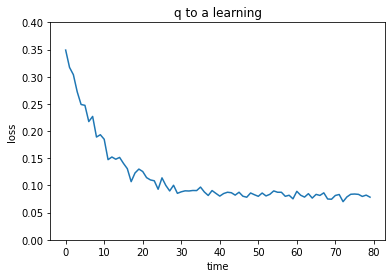

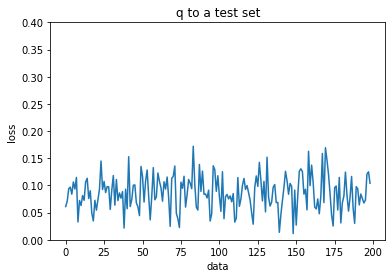

In [22]:
test_loss=[]
model.eval()

for data in test_data:
    x_test, y_test = data[0], data[1]

    with torch.no_grad():
        pred = model(x_test)
        loss = loss_fn(pred, y_test)
        test_loss.append(loss)
#         print("Loss", loss)
#         predicted, actual = pred, y_test
#         print(f'Predicted: "{predicted}", Actual: "{actual}"')

plt.figure()
plt.plot(loss_list)
axes = plt.gca()
plt.title('q to a learning')
plt.xlabel('time')
plt.ylabel('loss')
axes.set_ylim([0,0.4])
plt.show()

plt.figure()
plt.plot(test_loss)
axes = plt.gca()
plt.title('q to a test set')
plt.xlabel('data')
plt.ylabel('loss')
axes.set_ylim([0,0.4])
plt.show()